### List of tables:


1. [Table 3: Treatment effects on quantity](#quantity)

### List of figures:

2. [Figure S1: Time spent on intervention screen](#timer)

In [1]:
%matplotlib inline

#### Imports libraries

In [2]:
import matplotlib.pyplot as plt #plotting
import numpy as np #matrix algebra
import os #file system handling
import sys
import pandas as pd #dataframe handling
import re # regular expression
import statsmodels.api as sm #regression analysis
import statsmodels.formula.api as smf # regressions analysis

from matplotlib.ticker import FuncFormatter #formating graphs 
from scipy import stats #statistics module
from statsmodels.iolib.summary2 import summary_col #regression output table
from statsmodels.stats.anova import anova_lm #regression anova table
from statsmodels.stats.multicomp import MultiComparison #multi-comparisson tests 

#### Turn off pandas' future warnings

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#### Set project directory

In [4]:
PROJECT_FOLDER = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
FINAL_DATA_FOLDER = os.path.join(PROJECT_FOLDER, 'data', 'final')
TABLES_FOLDER = os.path.join(PROJECT_FOLDER, 'reports', 'tables')
FIGURES_FOLDER = os.path.join(PROJECT_FOLDER, 'reports', 'figures')

#### Set display format

In [5]:
pd.options.display.float_format = '{:.3f}'.format

#### Set plotting style

In [6]:
plt.style.use('classic')

#### Set plotting properties 

In [7]:
bar_kwargs = dict(kind='bar', color='0.4', alpha=0.8, lw=0.5, width=0.7)
line_kwargs = dict(kind='line', lw=1, alpha=1, legend=True)
tick_kwargs = dict(size=5, which='both', right=False, top=False, direction='out', labelbottom=True)
font_kwargs = dict(fontsize=11, color='k')
grid_kwargs = dict(linewidth=1, axis="y", zorder=2, antialiased=True)
xlabel_kwargs = dict(fontsize=11, labelpad=3)
ylabel_kwargs = dict(fontsize=11, labelpad=3)
e_kwargs = dict(elinewidth=2, ecolor='0.15')
legend_kwargs = dict(frameon=False)

#### Retrieving dataframe

In [8]:
DATA = os.path.join(FINAL_DATA_FOLDER, 'benefit_data.feather')
df = pd.read_feather(DATA)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3094 entries, 0 to 3093
Columns: 441 entries, age to question80_timer
dtypes: float64(223), int64(25), object(193)
memory usage: 10.4+ MB


#### Sort dataframe by treatment 

In [9]:
df = df.sort_values('treatment')

#### Exclude subjects for which the timer did not work (10 min +/- 5%)

In [10]:
broken_timer = (df.duration_work < 600 * 0.95)|(df.duration_work > 600 * 1.05)
df = df[~broken_timer]

#### Seperate quality concern-treatments from the following main analysys

In [11]:
sel = (df.dataset != 6)
df = df[sel]

#### Group datasets according to treatments

In [12]:
grouped_all = df.groupby('treatment_str')
grouped_first = df.groupby('treatment_first')
grouped_second = df.groupby('treatment_second')

#### Check for differences in the number of empty submissions across treatments <a id='counter_empty'></a>

In [13]:
regs = dict()
regs['reg1'] = 'counter_empty ~ low_piece_rate + high_piece_rate'
regs['reg2'] = 'counter_empty ~ expectations + goal'
regs['reg3'] = 'counter_empty ~ (low_piece_rate + high_piece_rate) * (expectations + goal)'
regs['reg4'] = regs['reg3'] + ' + age + female + education + mobile_device + latin'

ols_results = []
for k, v in regs.items():
    ols = smf.ols(formula=v, data=df).fit()
    ols = ols.get_robustcov_results()
    ols_results.append(ols)

order = [
    'low_piece_rate',
    'high_piece_rate',
    'expectations',
    'goal',
    'low_piece_rate:expectations',
    'high_piece_rate:expectations',
    'low_piece_rate:goal',
    'high_piece_rate:goal',
    'age',
    'female',
    'education',
    'mobile_device',
    'latin',
    'Intercept',
]

auxiliary = {
    'N': lambda x: "{:d}".format(int(x.nobs)),
    'R2': lambda x: "{:.3f}".format(x.rsquared)
}

summary = summary_col(
    ols_results,
    stars=True,
    info_dict=auxiliary,
    float_format='%.3f',
    regressor_order=order
)
summary = summary\
    .tables[0]\
    .rename(mapper=lambda x: x.replace('_', ' ').replace(':', ' * ').capitalize(), axis=0)\
    .rename(mapper=lambda x: x.capitalize().split()[0].replace('_', ' '), axis=1)\

display(summary)

,Counter empty,Counter empty,Counter empty,Counter empty
Low piece rate,0.070,,0.051,0.054
,(0.064),,(0.059),(0.059)
High piece rate,0.030,,0.003,0.002
,(0.028),,(0.016),(0.018)
Expectations,,-0.008,0.001,0.002
,,(0.021),(0.013),(0.015)
Goal,,0.084,0.030,0.030
,,(0.069),(0.028),(0.028)
Low piece rate * expectations,,,-0.049,-0.048
,,,(0.060),(0.063)


#### Histogram for number of sentences submitted  <a id='histogram_counter_real'></a>

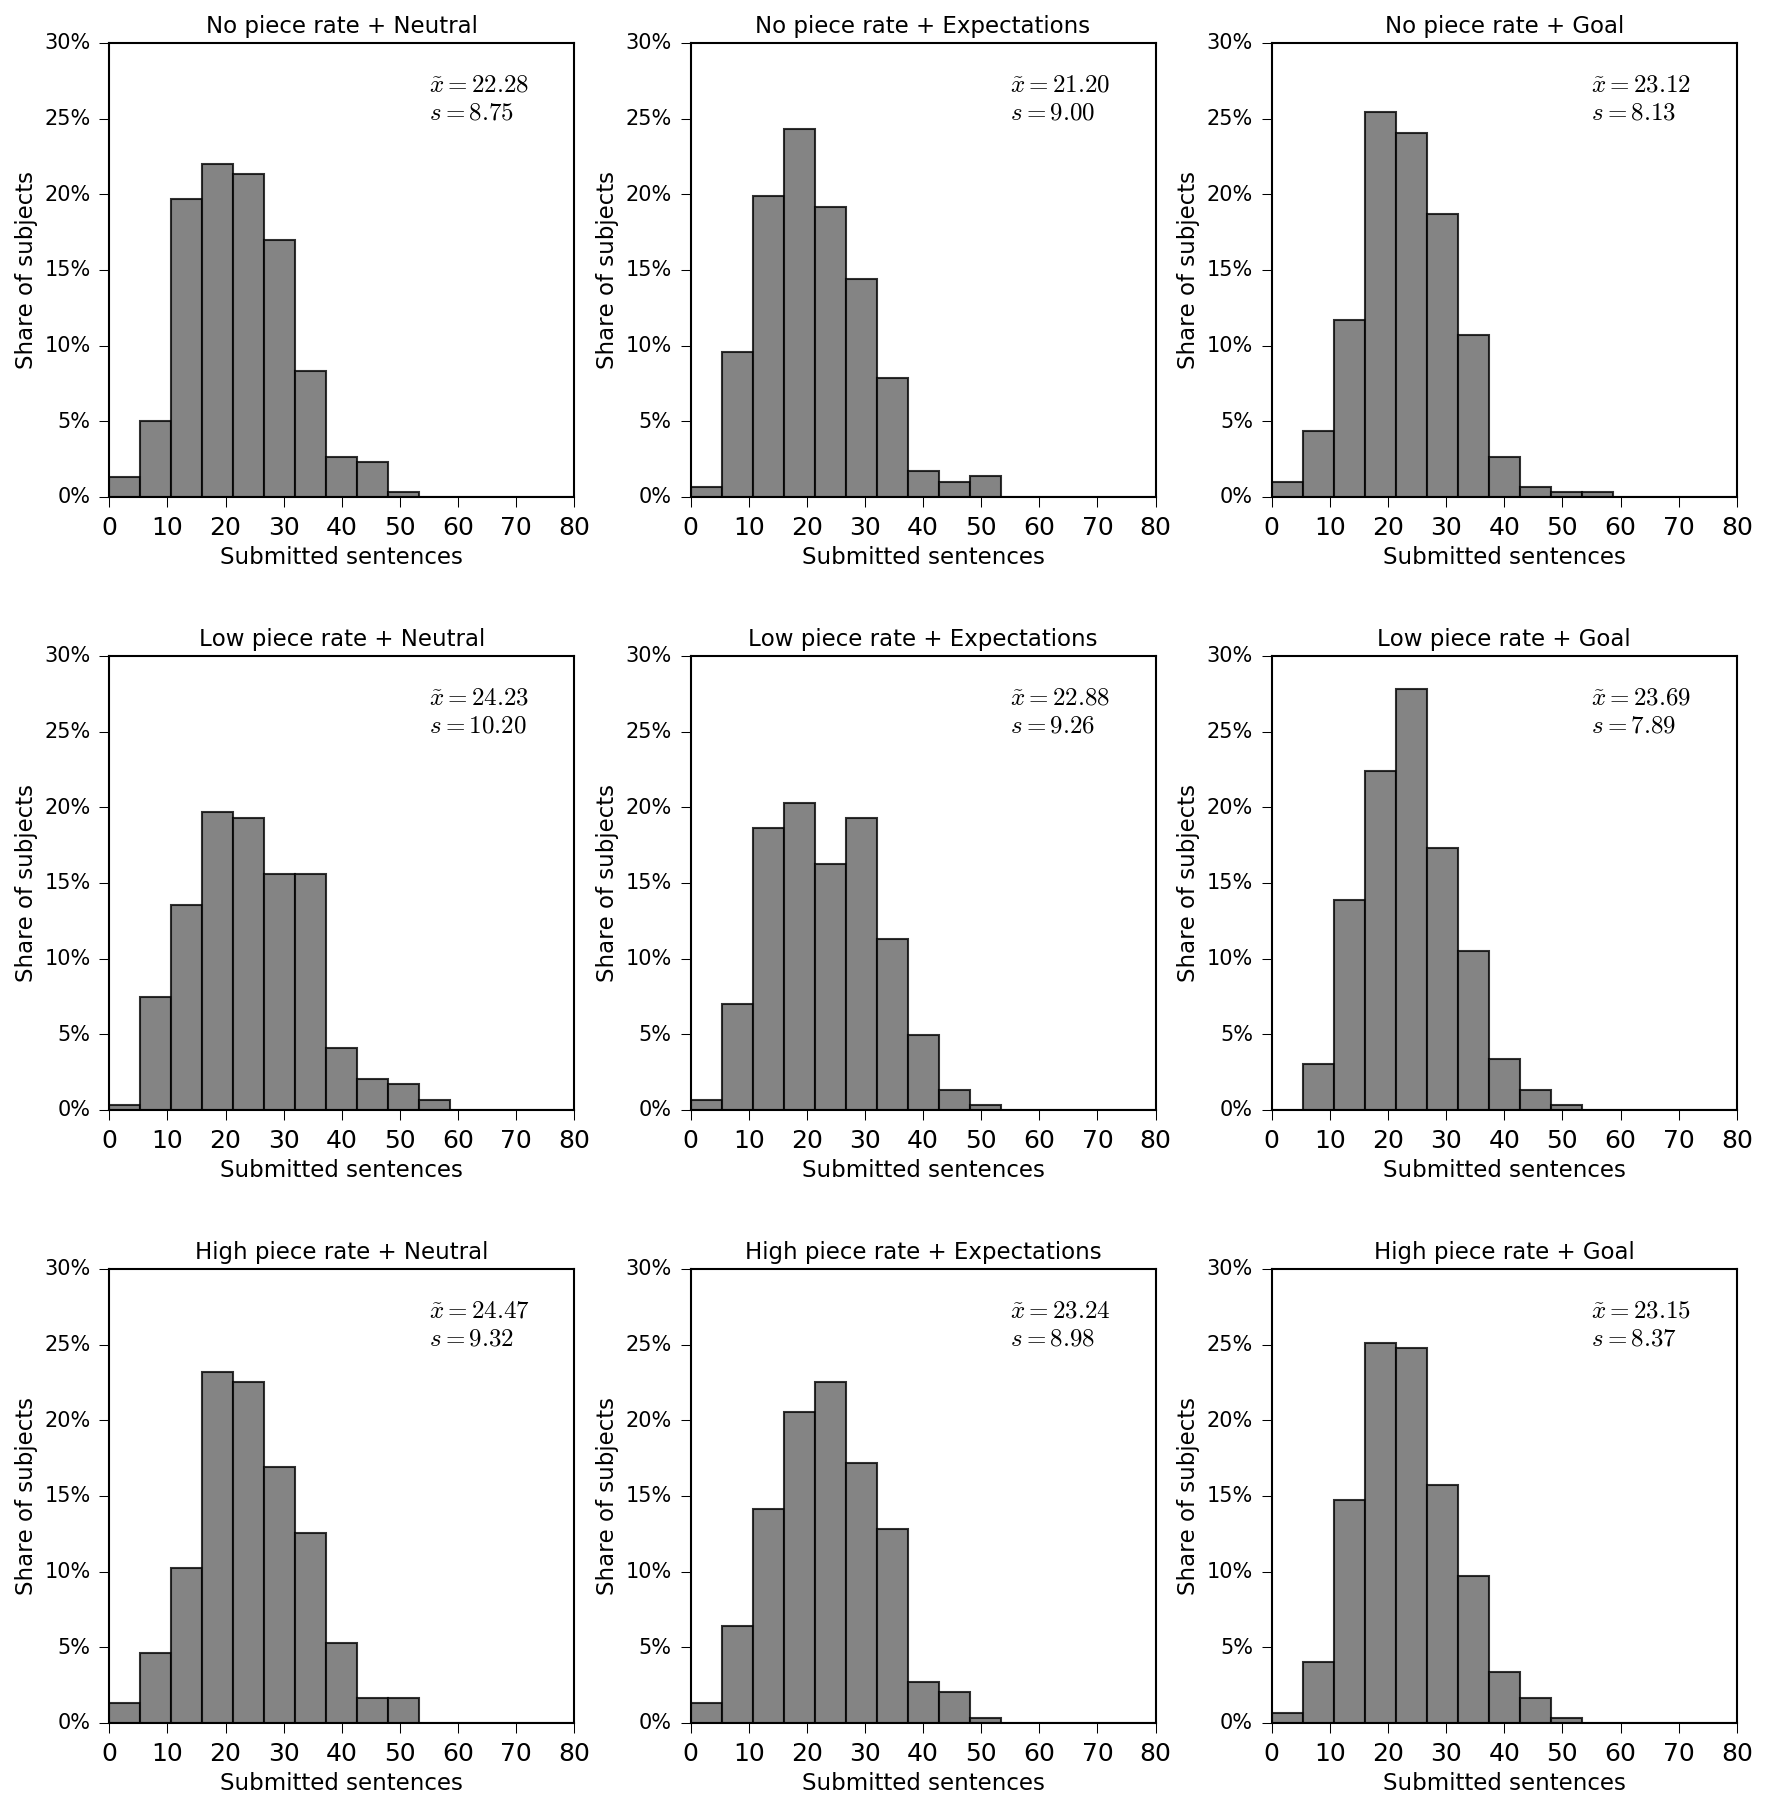

In [14]:
common_params = dict(bins=15, range=(0, 80), color='0.4', alpha=0.8, grid=False)
fig, axis = plt.subplots(ncols=3, nrows=3, sharey=True, figsize=(14, 14), dpi=150)
fig.set_facecolor('w')
fig.subplots_adjust(hspace=0.35, wspace=0.25)
for i, ax in enumerate(fig.axes):     
    ax.set_title(df.treatment_str.unique()[i], **font_kwargs)
    df_hist = df[df.treatment_str == df.treatment_str.unique()[i]]['counter_real']
    df_hist.hist(ax=ax, weights=np.ones(len(df_hist)) / len(df_hist), **common_params)
    ax.yaxis.set_major_formatter(FuncFormatter('{:.0%}'.format))
    ax.yaxis.set_ticks_position('left')
    ax.tick_params(axis='x', **tick_kwargs)
    ax.tick_params(axis='y', labelsize=10, **tick_kwargs)
    ax.set_xlabel("Submitted sentences", **xlabel_kwargs)
    ax.set_ylabel("Share of subjects", **ylabel_kwargs)
    mean, std = df_hist.mean(), df_hist.std()
    ax.text(55, 0.25 , "$\~{a}={b:.2f}$\n$s={c:.2f}$".format(a='x', b=mean, c=std))
plt.savefig(os.path.join(FIGURES_FOLDER, 'counter_real_hist.pdf'), bbox_inches='tight')

####  Plotting inverse cumulutative distribution function for fragments submitted

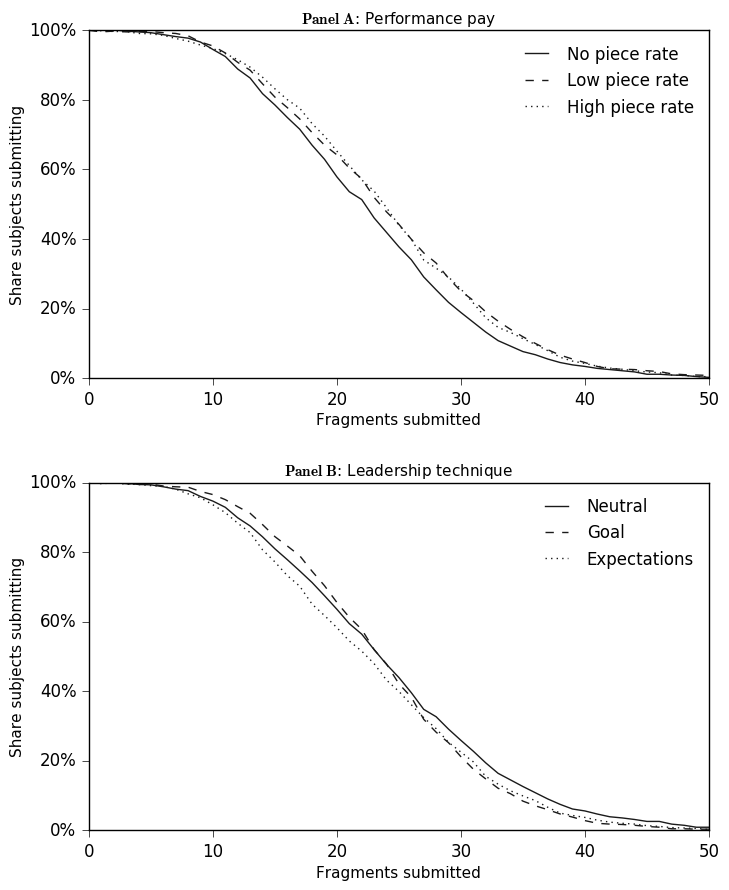

In [15]:
columns = ["question{}_answer".format(x) for x in range(1, df.counter.max() + 1)]

df_counter_first = grouped_first[columns]\
    .count()\
    .transpose()\
    .rename_axis('', axis=1)\
    .reset_index(drop=True)\
    .sort_index(axis=1, ascending=False)\
    .apply(lambda x: x/x.loc[0], axis=0)

df_counter_second = grouped_second[columns]\
    .count()\
    .transpose()\
    .rename_axis('', axis=1)\
    .reset_index(drop=True)\
    .sort_index(axis=1, ascending=False)\
    .apply(lambda x: x/x.loc[0], axis=0)

fig, axis = plt.subplots(nrows=2, figsize=(8, 10), dpi=100, facecolor='w')
fig.subplots_adjust(hspace=0.30)
axis[0].set_title('$\mathbf{Panel \ A}$: Performance pay', **font_kwargs)
axis[1].set_title('$\mathbf{Panel \ B}$: Leadership technique', **font_kwargs)
df_counter_first.plot(ax=axis[0], color='0.1', style=['-', '--',  ':'])
df_counter_second.plot(ax=axis[1], color='0.1', style=['-', '--', ':'])
for ax in axis:
    ax.tick_params(axis='x', **tick_kwargs)
    ax.tick_params(axis='y', labelsize='medium', **tick_kwargs)
    ax.set_xlabel("Fragments submitted", **xlabel_kwargs)
    ax.set_ylabel("Share subjects submitting", **ylabel_kwargs)
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
    ax.set_ylim(0.0, 1.0) 
    ax.set_xlim(0.0, 50)
    ax.legend(frameon=False, shadow=True, fontsize='medium')
plt.savefig(os.path.join(FIGURES_FOLDER, 'icdf.pdf'), bbox_inches='tight')

#### Pairwise sample distribution comparisson test for number of fragments submitted, first dimension

In [16]:
mct = MultiComparison(df.counter_real, df.treatment_first)
mct.allpairtest(stats.ks_2samp, method='Holm')[0]

group1,group2,stat,pval,pval_corr,reject
High piece rate,Low piece rate,0.0354,0.6118,0.6118,False
High piece rate,No piece rate,0.0782,0.0078,0.0234,True
Low piece rate,No piece rate,0.0752,0.0129,0.0259,True


#### Pairwise T-test of mean differences for number of fragments submitted, first dimension

In [17]:
mct.allpairtest(stats.ttest_ind, method='Holm')[0]

group1,group2,stat,pval,pval_corr,reject
High piece rate,Low piece rate,0.0647,0.9484,0.9484,False
High piece rate,No piece rate,3.4065,0.0007,0.002,True
Low piece rate,No piece rate,3.2827,0.001,0.0021,True


#### Pairwise variance comparisson test for number of fragments submitted, first dimension

In [18]:
mct.allpairtest(stats.levene, method='Holm')[0]

group1,group2,stat,pval,pval_corr,reject
High piece rate,Low piece rate,1.377,0.2408,0.4816,False
High piece rate,No piece rate,0.4227,0.5157,0.5157,False
Low piece rate,No piece rate,3.398,0.0654,0.1963,False


#### Compare average number of fragments submitted, first dimension

In [19]:
counter_first = grouped_first['counter_real']\
    .agg(['mean', 'sem', 'count'])\
    .sort_index(axis=0, ascending=False)

display(counter_first)

,mean,sem,count
treatment_first,,,
No piece rate,22.209,0.290,891
Low piece rate,23.596,0.307,891
High piece rate,23.624,0.297,898


#### Plot average number of fragments submitted, first treatment dimension

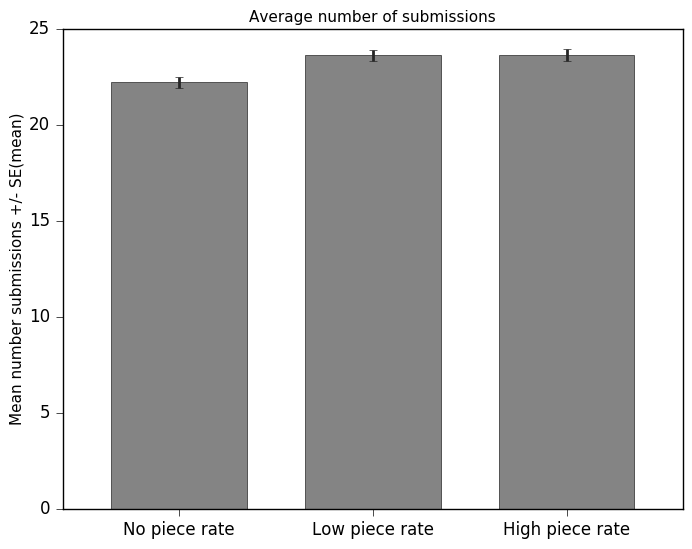

In [20]:
fig, ax = plt.subplots(figsize=(8, 6), dpi=100, facecolor='w')
counter_first['mean'].plot(yerr=counter_first['sem'], ax=ax, error_kw=e_kwargs, **bar_kwargs)
ax.set_title('Average number of submissions', **font_kwargs)
ax.tick_params(axis='x', rotation=0, **tick_kwargs)
ax.tick_params(axis='y', **tick_kwargs)
ax.set_ylabel("Mean number submissions +/- SE(mean)", **ylabel_kwargs)
ax.set_xlabel("") 
plt.savefig(os.path.join(FIGURES_FOLDER, 'counter_real_first.pdf'), bbox_inches='tight')
plt.show()

#### Pairwise sample distribution comparisson test for number of fragments submitted, second dimension

In [21]:
mct = MultiComparison(df.counter_real, df.treatment_second)
mct.allpairtest(stats.ks_2samp, method='Holm')[0]

group1,group2,stat,pval,pval_corr,reject
Expectations,Goal,0.1008,0.0002,0.0006,True
Expectations,Neutral,0.0632,0.0532,0.1064,False
Goal,Neutral,0.0505,0.1944,0.1944,False


####  Pairwise T-test of mean differences for number of fragments submitted, second dimension

In [22]:
mct.allpairtest(stats.ttest_ind, method='Holm')[0]

group1,group2,stat,pval,pval_corr,reject
Expectations,Goal,-2.1349,0.0329,0.0658,False
Expectations,Neutral,-2.7416,0.0062,0.0185,True
Goal,Neutral,-0.7977,0.4251,0.4251,False


####  Pairwise variance comparisson test for number of fragments submitted, second dimension

In [23]:
mct.allpairtest(stats.levene, method='Holm')[0]

group1,group2,stat,pval,pval_corr,reject
Expectations,Goal,17.938,0.0,0.0,True
Expectations,Neutral,0.2154,0.6426,0.6426,False
Goal,Neutral,20.4256,0.0,0.0,True


#### Compare average number of fragments submitted, second dimension

In [24]:
counter_second = grouped_second['counter_real']\
    .agg(['mean', 'sem', 'count'])\
    .sort_index(axis=0, ascending=False)
    
display(counter_second)

,mean,sem,count
treatment_second,,,
Neutral,23.656,0.316,897
Goal,23.323,0.272,893
Expectations,22.449,0.305,890


#### Plot average number of submissions, second treatment dimension

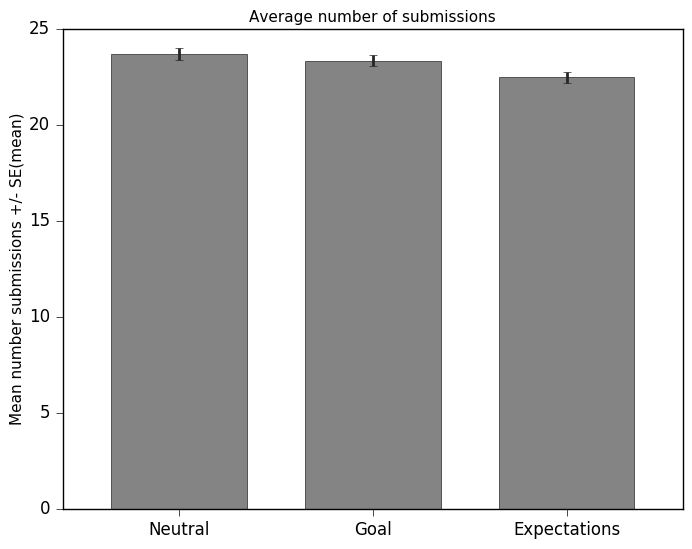

In [25]:
fig, ax = plt.subplots(figsize=(8, 6), dpi=100, facecolor='w')
ax.set_title('Average number of submissions', **font_kwargs)
counter_second['mean'].plot(yerr=counter_second['sem'], ax=ax, error_kw=e_kwargs, **bar_kwargs)
ax.tick_params(axis='x', rotation=0, **tick_kwargs)
ax.tick_params(axis='y', **tick_kwargs)
ax.set_xlabel("") 
ax.set_ylabel("Mean number submissions +/- SE(mean)", **ylabel_kwargs)
plt.savefig(os.path.join(FIGURES_FOLDER, 'counter_real_second.pdf'))
plt.show()

#### Cross tabulate average number of fragments submitted

In [26]:
counter_cross = pd.crosstab(
    df['treatment_first'],
    df['treatment_second'],
    values= df['counter_real'],
    aggfunc='mean',
    margins=True
)\
.reindex(pd.Index(['No piece rate', 'Low piece rate', 'High piece rate', 'All']))\
.reindex(pd.Index(['Neutral', 'Expectations', 'Goal', 'All']), axis=1)

display(counter_cross)

,Neutral,Expectations,Goal,All
No piece rate,22.277,21.202,23.124,22.209
Low piece rate,24.227,22.880,23.695,23.596
High piece rate,24.467,23.239,23.154,23.624
All,23.656,22.449,23.323,23.144


#### Table 3: Treatment effects on quantity <a id='quantity'></a>

In [27]:
regs = dict()
regs['reg1'] = 'counter_real ~ low_piece_rate + high_piece_rate'
regs['reg2'] = 'counter_real ~ expectations + goal'
regs['reg3'] = 'counter_real ~ (low_piece_rate + high_piece_rate) * (expectations + goal)'
regs['reg4'] = regs['reg3'] + ' + age + female + education + mobile_device + latin'

ols_results = []
for k, v in regs.items():
    ols = smf.ols(formula=v, data=df).fit()
    ols = ols.get_robustcov_results()
    ols_results.append(ols)

order = [
    'low_piece_rate',
    'high_piece_rate',
    'expectations',
    'goal',
    'low_piece_rate:expectations',
    'high_piece_rate:expectations',
    'low_piece_rate:goal',
    'high_piece_rate:goal',
    'age',
    'female',
    'education',
    'mobile_device',
    'latin',
    'Intercept',
]

auxiliary = {
    'N': lambda x: "{:d}".format(int(x.nobs)),
    'R2': lambda x: "{:.3f}".format(x.rsquared)
}
ols_quant = summary_col(
    ols_results,
    stars=True,
    info_dict=auxiliary,
    float_format='%.3f',
    regressor_order=order
)
ols_quant = ols_quant\
    .tables[0]\
    .rename(mapper=lambda x: x.replace('_', ' ').replace(':', ' * ').capitalize(), axis=0)\
    .rename(mapper=lambda x: x.capitalize().split()[0].replace('_', ' '), axis=1)\

ols_quant.to_latex(
    os.path.join(TABLES_FOLDER, 'ols_quantity.tex'),
    bold_rows=True,
    float_format="%.3f"
)
display(ols_quant)

,Counter real,Counter real,Counter real,Counter real
Low piece rate,1.387***,,1.950**,1.990***
,(0.423),,(0.780),(0.750)
High piece rate,1.415***,,2.190***,1.983***
,(0.415),,(0.737),(0.719)
Expectations,,-1.206***,-1.075,-1.280*
,,(0.440),(0.730),(0.704)
Goal,,-0.333,0.847,0.794
,,(0.417),(0.690),(0.670)
Low piece rate * expectations,,,-0.272,-0.474
,,,(1.082),(1.041)


In [28]:
anova_lm(*ols_results, robust='hc3')

/home/sebastian/.virtualenvs/hidden_benefit_publication/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/sebastian/.virtualenvs/hidden_benefit_publication/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/sebastian/.virtualenvs/hidden_benefit_publication/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,2677.000,212790.497,0.000,nan,nan,nan
1,2677.000,213265.897,-0.000,-475.401,inf,nan
2,2671.000,211643.676,6.000,1622.222,3.672,0.001
3,2666.000,196296.573,5.000,15347.102,41.687,0.000
